# Kings County Housing Prices Bakeoff

Below are a list of steps that you should take while trying to complete your bake-off entry.

# Step 1: Read in Data

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 400)
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
from statsmodels.formula.api import ols

from sklearn import linear_model
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression


df = pd.read_csv('Resources/kc_house_data_train.csv', index_col=0)
df = df.drop(['id'], axis=1)

In [3]:
#adjusting bedrooms outliers 
df['bedrooms'] = df['bedrooms'].apply(lambda x : 9 if x > 9 else x)
#np.where(df['my_channel'] > 20000, 0, df['my_channel'])

In [4]:
#Run below cell for heatmap of correlations

In [5]:
# #create a heatmap to visualize the correlations
# fig, ax = plt.subplots(figsize=(25,15)) # figsize to make larger
# corr = df.corr()

# # Generate a mask for the upper triangle
# mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

# sns.heatmap(corr, mask=mask, cmap='bwr', center=0, annot=True)

# # fix for matplotlib bug that cuts off top/bottom of seaborn viz
# b, t = plt.ylim() # discover the values for bottom and top
# b += 0.5 # Add 0.5 to the bottom
# t -= 0.5 # Subtract 0.5 from the top
# plt.ylim(b, t) # update the ylim(bottom, top) values

# plt.show()

# Step 2: EDA
### Initial Findings and planning
- **highest correlations:** 'bathrooms', 'sqft_living', 'grade', 'sqft_above', 'sqft_living15' (check for outliers and extreme values)
    - sqft_living seems like a better predictor
- **suprisingly low correlations:** 'bedrooms', 'waterfront', 'view', 'condition', 'renovated_0' (manipulate to create higher correlations)
- check out for outliers in price by sqft
- 33 bedrooms outlier
- bin `condition` into 3 categories: 1/2, 3/4, and 5
- bin `view` into 3 categories: 0, 1&2, 3, 4 (create poly?)
- `grade` poly?
- dummy code zip codes
- check out distances from Seattle city center with `lat` and `long`
- viz for floors
- waterfront: t-test

In [6]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050


In [7]:
#changing date format workable month/year

df['yr_sold'] = pd.to_datetime(df['date'].str.slice(0,8), format='%Y%m%d', errors='ignore').dt.year
df['month_sold'] = pd.to_datetime(df['date'].str.slice(0,8), format='%Y%m%d', errors='ignore').dt.month
df.drop('date',axis=1,inplace=True)

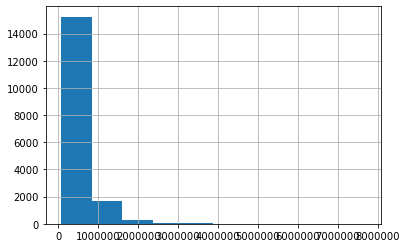

In [8]:
df.price.hist()

**almost normal: price by sqft, sqft_living, yr_built**

In [9]:
#log:sqft_above, sqft_living, sqft_living15, 

In [10]:
# Run below cell for histograms

In [11]:
# df.hist(bins=50, figsize=(20,15))
# plt.show()

Bin groups: Condition (1&2, 3&4, 5); View (0, 1&2, 3&4)

polynomial grade,  `df['grade_exp'] = np.exp(df['grade'])`, view(?)

waterfront: t-test

In [12]:
#Run below cell for pairplot

In [13]:
# sns.pairplot(df[['bathrooms', 'bedrooms', 'lat', 'long', 'month_sold', 'sqft_above', 'sqft_basement', 'sqft_living', 'grade', 'sqft_living15', 'sqft_lot', 'sqft_lot15', 'yr_built', 'yr_renovated', 'price']], corner=True)


In [14]:
# # Bar plots of categorical data
# #zipcode explored later
# fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15,10))

# categoricals = ['condition', 'floors', 'grade', 'month_sold', 'yr_sold', 'view', 'waterfront']

# for col, ax in zip(categoricals, axes.flatten()):
#     (df.groupby(col)               # group values together by column of interest
#          .mean()['price']        # take the mean of the saleprice for each group
#          .plot
#          .bar(ax=ax))                # create a bar graph on the ax    
#     ax.set_title(col)                # Make the title the name of the column
# fig.tight_layout()

In [15]:
list(df.columns)

['price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'yr_sold',
 'month_sold']

In [16]:
df.info()
# all dtypes are ints and floats, one object: 'date'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17290 entries, 0 to 17289
Data columns (total 21 columns):
price            17290 non-null float64
bedrooms         17290 non-null int64
bathrooms        17290 non-null float64
sqft_living      17290 non-null int64
sqft_lot         17290 non-null int64
floors           17290 non-null float64
waterfront       17290 non-null int64
view             17290 non-null int64
condition        17290 non-null int64
grade            17290 non-null int64
sqft_above       17290 non-null int64
sqft_basement    17290 non-null int64
yr_built         17290 non-null int64
yr_renovated     17290 non-null int64
zipcode          17290 non-null int64
lat              17290 non-null float64
long             17290 non-null float64
sqft_living15    17290 non-null int64
sqft_lot15       17290 non-null int64
yr_sold          17290 non-null int64
month_sold       17290 non-null int64
dtypes: float64(5), int64(16)
memory usage: 2.9 MB


In [17]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yr_sold,month_sold
count,1.729000e+04,17290.000000,17290.000000,17290.000000,1.729000e+04,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000
mean,5.407395e+05,3.370792,2.111943,2081.464604,1.524340e+04,1.490312,0.007981,0.238519,3.408502,7.654425,1789.306015,292.158589,1970.792019,83.806304,98078.193175,47.560058,-122.214258,1987.986698,12873.475824,2014.323135,6.570561
std,3.733190e+05,0.910916,0.770476,920.018539,4.230462e+04,0.538909,0.088985,0.775229,0.651296,1.174718,829.265107,443.151874,29.343516,400.329376,53.607949,0.138412,0.140857,684.802635,27227.437583,0.467687,3.116999
min,7.500000e+04,0.000000,0.000000,290.000000,5.720000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,659.000000,2014.000000,1.000000
25%,3.210000e+05,3.000000,1.500000,1430.000000,5.081250e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1951.000000,0.000000,98033.000000,47.471200,-122.329000,1490.000000,5111.250000,2014.000000,4.000000
50%,4.500000e+05,3.000000,2.250000,1920.000000,7.642000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1974.000000,0.000000,98065.000000,47.571600,-122.230000,1840.000000,7622.500000,2014.000000,6.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.072575e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2214.500000,560.000000,1996.000000,0.000000,98118.000000,47.677900,-122.126000,2360.000000,10101.750000,2015.000000,9.000000
max,7.700000e+06,9.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,858132.000000,2015.000000,12.000000


# Investigation

### Outcome Variable: Price
may keep `price` as-is -- perhaps bring outliers down to 6000000? Let's see how models do with both options

NOTE: may help to normalize/scale/log

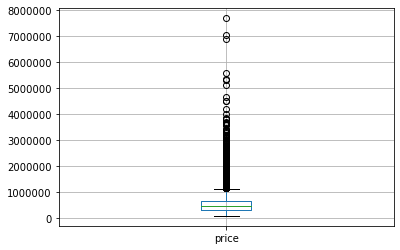

In [18]:
df.boxplot(['price'])

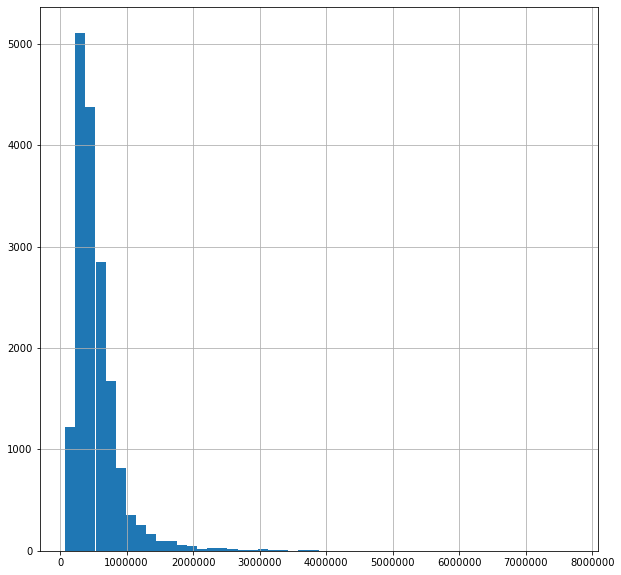

In [19]:
df.price.hist(bins=50, figsize=(10,10))
plt.show()

#### Price by square feet (checking for outliers)

In [4]:
## Creating new feature: price per square feet
df['price_by_sqft'] = df.price/df.sqft_living

In [21]:
#Checking out highest priced homes
df.loc[df.price > 5000000].sort_values('price_by_sqft')

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yr_sold,month_sold,price_by_sqft
2232,5570000.0,5,5.75,9200,35069,2.0,0,0,3,13,6200,3000,2001,0,98039,47.6289,-122.233,3560,24345,2014,8,605.434783
14668,5110800.0,5,5.25,8010,45517,2.0,1,4,3,12,5990,2020,1999,0,98033,47.6767,-122.211,3430,26788,2014,10,638.052434
10366,7700000.0,6,8.00,12050,27600,2.5,0,3,4,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800,2014,10,639.004149
1979,5350000.0,5,5.00,8000,23985,2.0,0,4,3,12,6720,1280,2009,0,98004,47.6232,-122.220,4600,21750,2015,4,668.750000
7519,6885000.0,6,7.75,9890,31374,2.0,0,4,3,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730,2014,9,696.157735
6903,7062500.0,5,4.50,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449,2014,6,703.436255
5039,5300000.0,6,6.00,7390,24829,2.0,1,4,4,12,5000,2390,1991,0,98040,47.5631,-122.210,4320,24619,2015,4,717.185386


In [22]:
df.loc[df.price < 1000000].sort_values('price_by_sqft').head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yr_sold,month_sold,price_by_sqft
2709,148900.0,4,1.75,1700,6000,1.0,0,0,3,7,1700,0,1967,0,98002,47.3252,-122.208,1280,6000,2014,12,87.588235
11036,149000.0,3,1.00,1700,8645,1.0,0,0,3,6,1700,0,1955,0,98146,47.4899,-122.337,1500,7980,2014,5,87.647059
5589,257000.0,5,2.75,2930,10148,2.0,0,0,3,9,2930,0,2002,0,98059,47.4887,-122.145,2930,8425,2014,10,87.713311
12735,110000.0,3,1.00,1250,53143,1.0,0,0,5,6,1250,0,1945,0,98038,47.4235,-122.051,1820,217800,2014,5,88.000000
8877,250000.0,3,1.50,2840,10182,1.0,0,0,3,8,1510,1330,1951,0,98056,47.5240,-122.200,2210,9669,2015,1,88.028169


In [23]:
df.sort_values('price_by_sqft').head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yr_sold,month_sold,price_by_sqft
2709,148900.0,4,1.75,1700,6000,1.0,0,0,3,7,1700,0,1967,0,98002,47.3252,-122.208,1280,6000,2014,12,87.588235
11036,149000.0,3,1.00,1700,8645,1.0,0,0,3,6,1700,0,1955,0,98146,47.4899,-122.337,1500,7980,2014,5,87.647059
5589,257000.0,5,2.75,2930,10148,2.0,0,0,3,9,2930,0,2002,0,98059,47.4887,-122.145,2930,8425,2014,10,87.713311
12735,110000.0,3,1.00,1250,53143,1.0,0,0,5,6,1250,0,1945,0,98038,47.4235,-122.051,1820,217800,2014,5,88.000000
8877,250000.0,3,1.50,2840,10182,1.0,0,0,3,8,1510,1330,1951,0,98056,47.5240,-122.200,2210,9669,2015,1,88.028169


In [24]:
df = df.drop(['price_by_sqft'], axis=1)

## Zipcode 
create dummy codes in feature creation

In [25]:
df.zipcode.value_counts().count()

70

In [26]:
#DF of price and zipcode
df[['price', 'zipcode']].sort_values('price')

## Next step: get mean of price for each zipcode

,price,zipcode
9060,75000.0,98022
4869,78000.0,98168
9193,80000.0,98014
15956,82000.0,98146
1269,82500.0,98168
...,...,...
1979,5350000.0,98004
2232,5570000.0,98039
7519,6885000.0,98039
6903,7062500.0,98004


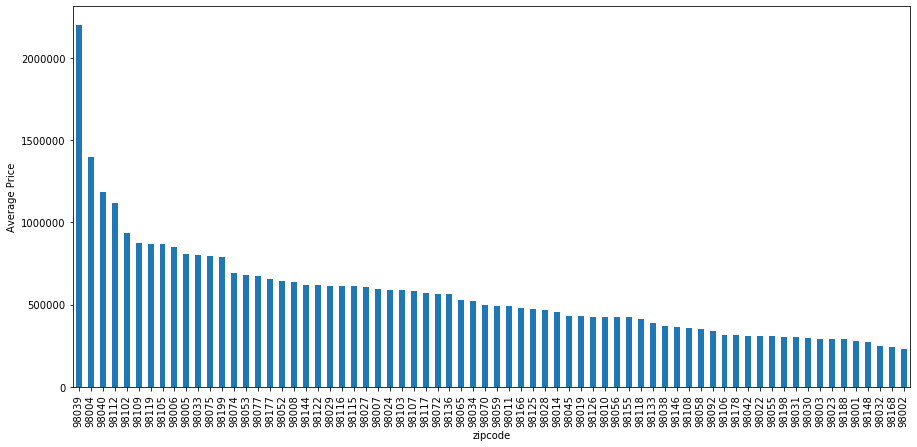

In [27]:
zip_means = df.groupby(['zipcode']).price.mean().sort_values(ascending=False)
plt.figure(figsize=(15,7))
plt.ylabel('Average Price')
zip_means.plot(kind='bar')

## Floors
create dummy codes in feature creation

Text(0.5, 0, 'Floors')

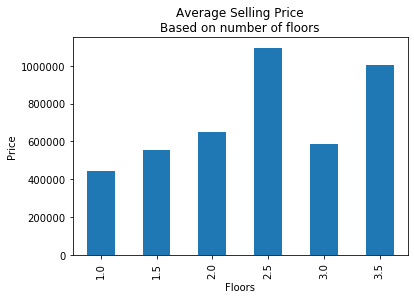

In [28]:
#Barplot Price v number of floors
df.groupby('floors')['price'].mean().plot(kind='bar')

#Set labels
plt.title('Average Selling Price\nBased on number of floors', size=12)
plt.ylabel('Price')
plt.xlabel('Floors')

In [5]:
df['floors_x_sqft_living'] = df['floors']*df['sqft_living']


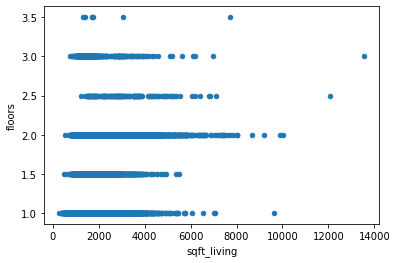

In [30]:
df.plot(kind='scatter', x='sqft_living', y='floors')

In [31]:
#df = df.drop(['floors_x_sqft_living'], axis=1)

## Strong correlations (plots)
- cap square foot living
- Checking for outliers and trends in grade, bathrooms, sqft_living, sqft_above, sqft_living15

In [32]:
cols = ['bathrooms', 'sqft_living', 'grade', 'sqft_living15', 'price']
#break the colums in to groups to plot 4 on a row at a time
n = 5
row_groups= [cols[i:i+n] for i in range(0, len(cols), n) ]

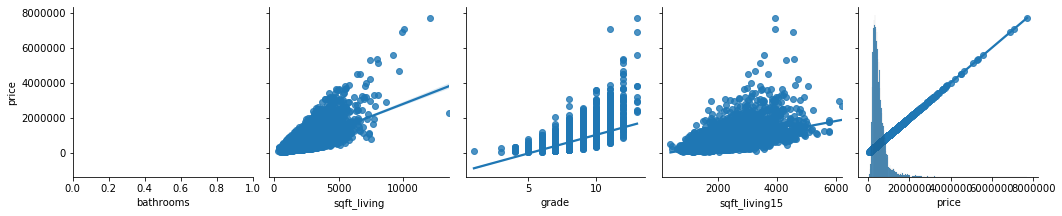

In [33]:
for i in row_groups:
    pp = sns.pairplot(data=df[cols], y_vars='price',x_vars=i, kind="reg", height=3)

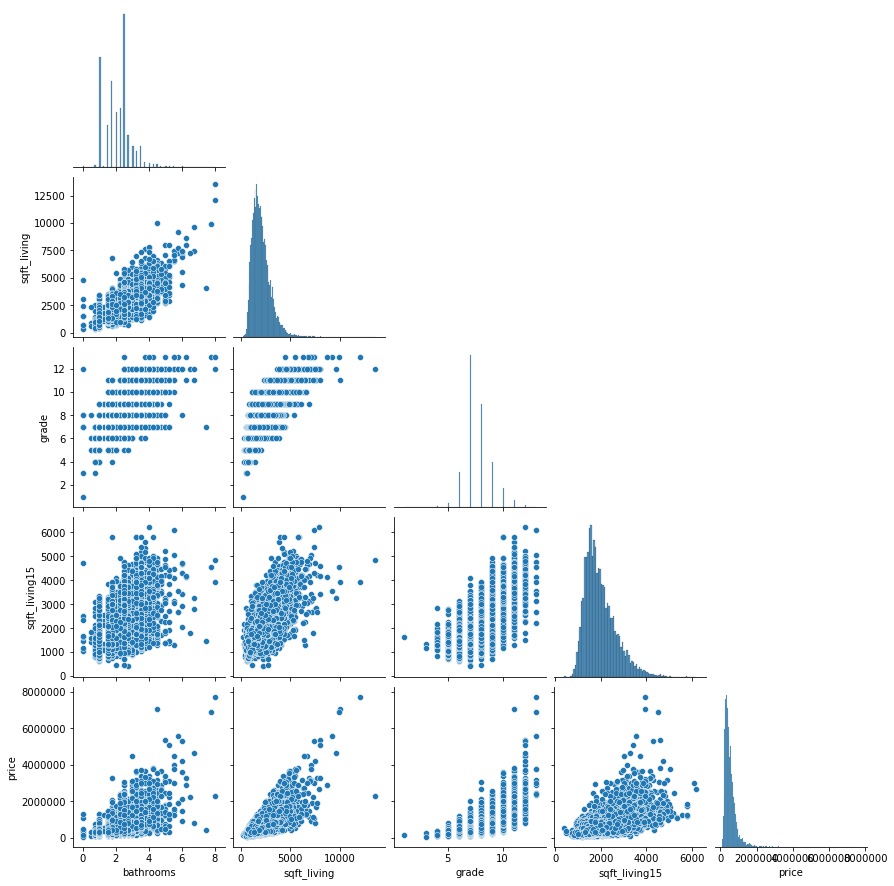

In [34]:
sns.pairplot(df[['bathrooms', 'sqft_living', 'grade', 'sqft_living15', 'price']], corner=True)

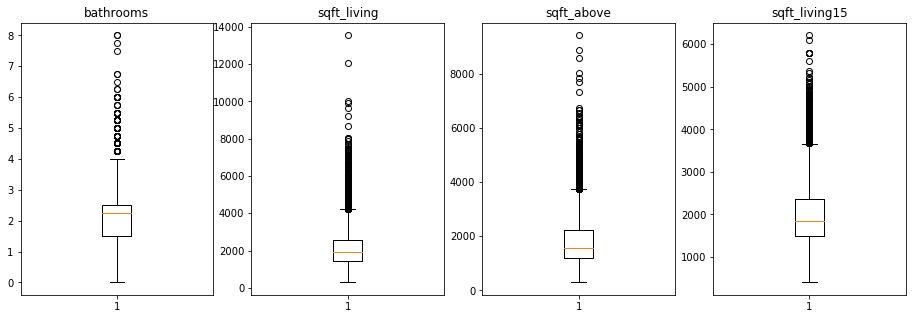

In [35]:
plt.figure(figsize=(20,5))

# ax3 = plt.subplot(1, 5, 1)
# plt.boxplot(df.grade)
# ax3.set_title('grade')

ax1 = plt.subplot(1, 5, 2)
plt.boxplot(df.bathrooms)
ax1.set_title('bathrooms')

ax2 = plt.subplot(1, 5, 3)
plt.boxplot(df.sqft_living)
ax2.set_title('sqft_living')


ax3 = plt.subplot(1, 5, 4)
plt.boxplot(df.sqft_above)
ax3.set_title('sqft_above')

ax3 = plt.subplot(1, 5, 5)
plt.boxplot(df.sqft_living15)
ax3.set_title('sqft_living15')

plt.show()

### 1. Bathrooms

Text(0.5, 0, 'Bathrooms')

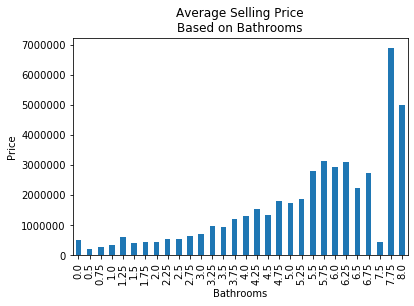

In [36]:
#Barplot Price v Bathrooms
df.groupby('bathrooms')['price'].mean().plot(kind='bar')

#Set labels
plt.title('Average Selling Price\nBased on Bathrooms', size=12)
plt.ylabel('Price')
plt.xlabel('Bathrooms')

In [37]:
# #Run model without this parameter first
# df['bathrooms'] = np.where(df.bathrooms>6, 6, df['bathrooms'])

In [38]:
#df.bathrooms.value_counts()

Text(0.5, 0, 'Bathrooms')

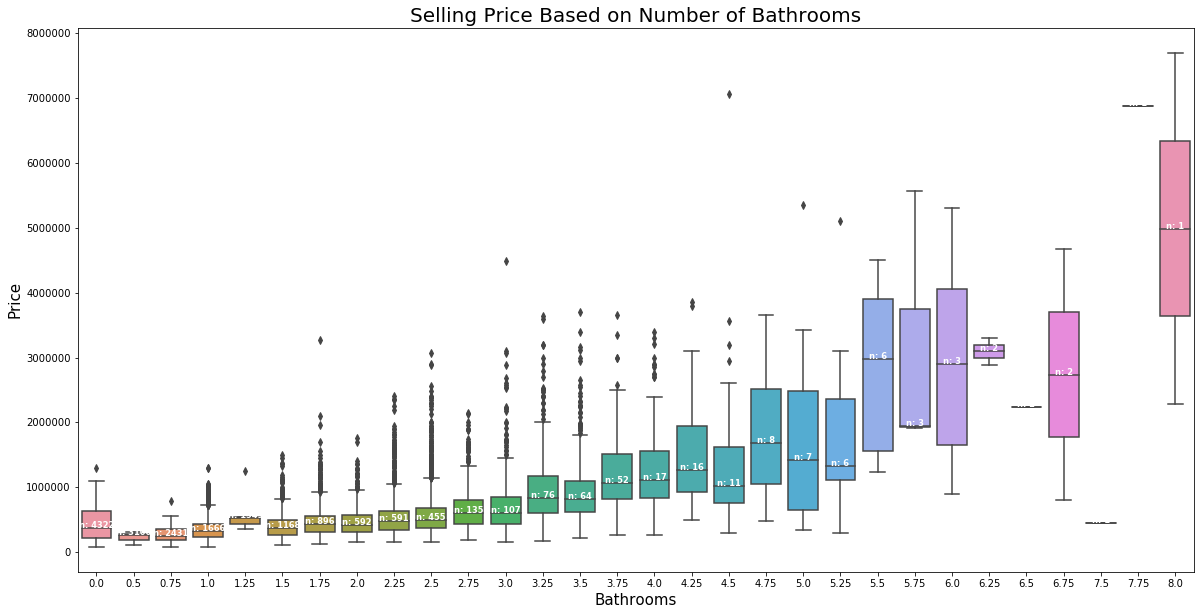

In [39]:
plt.figure(figsize=(20,10))
ax = sns.boxplot(x=df['bathrooms'], y=df['price'], data=df)
 
# Calculate number of obs per group & median to position labels
medians = df.groupby(['bathrooms'])['price'].median().values
nobs = df['bathrooms'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 0.03, nobs[tick],
horizontalalignment='center', size='small', color='w', weight='semibold')
    
plt.title('Selling Price Based on Number of Bathrooms', size=20)
plt.ylabel('Price', size=15)
plt.xlabel('Bathrooms', size=15)

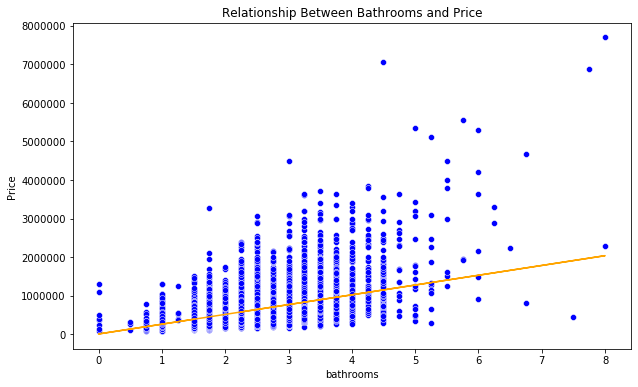

In [40]:
plt.subplots(figsize = (10,6))
ax = sns.scatterplot(x="bathrooms", y="price", data=df, color = 'blue')
ax.set(xlabel="bathrooms", ylabel = "Price", title="Relationship Between Bathrooms and Price")
x=df["bathrooms"]
y=df["price"]
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color = 'orange')

### 2. Grade - Construction Rating

Text(0.5, 0, 'Building and Construction Rating')

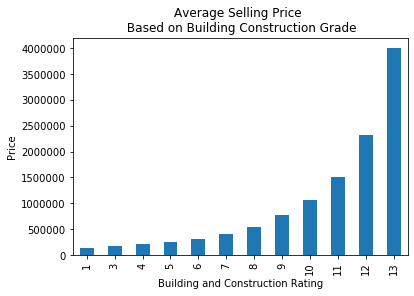

In [41]:
#Barplot Price v Grade
df.groupby('grade')['price'].mean().plot(kind='bar')

#Set labels
plt.title('Average Selling Price \n Based on Building Construction Grade', size=12)
plt.ylabel('Price')
plt.xlabel('Building and Construction Rating')

### 3. Square Foot Living

In [42]:
df.sort_values('sqft_living')

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yr_sold,month_sold,floors_x_sqft_living
10067,142000.0,0,0.00,290,20875,1.0,0,0,1,1,290,0,1963,0,98024,47.5308,-121.888,1620,22850,2014,9,290.0
7263,276000.0,1,0.75,370,1801,1.0,0,0,5,5,370,0,1923,0,98117,47.6778,-122.389,1340,5000,2014,7,370.0
2430,265000.0,0,0.75,384,213444,1.0,0,0,3,4,384,0,2003,0,98070,47.4177,-122.491,1920,224341,2014,10,384.0
13989,228000.0,0,1.00,390,5900,1.0,0,0,2,4,390,0,1953,0,98118,47.5260,-122.261,2170,6000,2014,10,390.0
6345,245000.0,1,1.00,390,2000,1.0,0,0,4,6,390,0,1920,0,98103,47.6938,-122.347,1340,5100,2015,5,390.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15816,4668000.0,5,6.75,9640,13068,1.0,1,4,3,12,4820,4820,1983,2009,98040,47.5570,-122.210,3270,10454,2014,6,9640.0
7519,6885000.0,6,7.75,9890,31374,2.0,0,4,3,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730,2014,9,19780.0
6903,7062500.0,5,4.50,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449,2014,6,20080.0
10366,7700000.0,6,8.00,12050,27600,2.5,0,3,4,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800,2014,10,30125.0


In [43]:
above_6std = df.price.mean()+(6*df.sqft_living.std())
above_6std

546259.6598772238

In [44]:
above_6std = df.price.mean()+(6*df.sqft_above.std())
above_6std

545715.1392829734

## Suprisingly weak correlations
- 'bedrooms', 'waterfront', 'view', 'condition', ('renovated_0' for later)

In [45]:
#Run below cell for pairplot

In [46]:
# sns.pairplot(df[['bathrooms', 'sqft_living', 'grade', 'sqft_living15', 'price']], corner=True)
# plt.show()

## Bedrooms
poly3, cat, or normal?

Text(0.5, 0, 'Bedrooms')

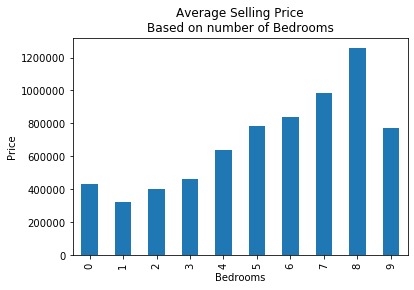

In [47]:
#Barplot Price v number of floors
df.groupby('bedrooms')['price'].mean().plot(kind='bar')

#Set labels
plt.title('Average Selling Price\nBased on number of Bedrooms', size=12)
plt.ylabel('Price')
plt.xlabel('Bedrooms')

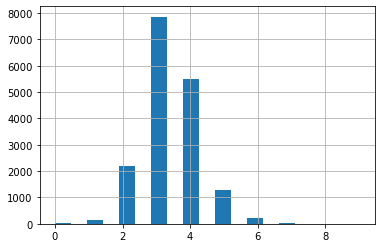

In [48]:
df.bedrooms.hist(bins=19)
plt.show()

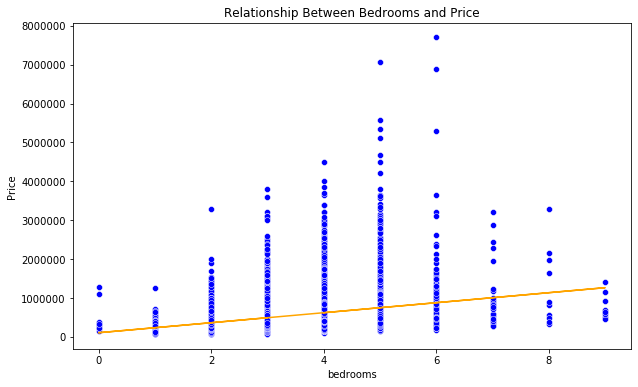

In [49]:
plt.subplots(figsize = (10,6))
ax = sns.scatterplot(x="bedrooms", y="price", data=df, color = 'blue')
ax.set(xlabel="bedrooms", ylabel = "Price", title="Relationship Between Bedrooms and Price")
x=df["bedrooms"]
y=df["price"]
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color = 'orange')

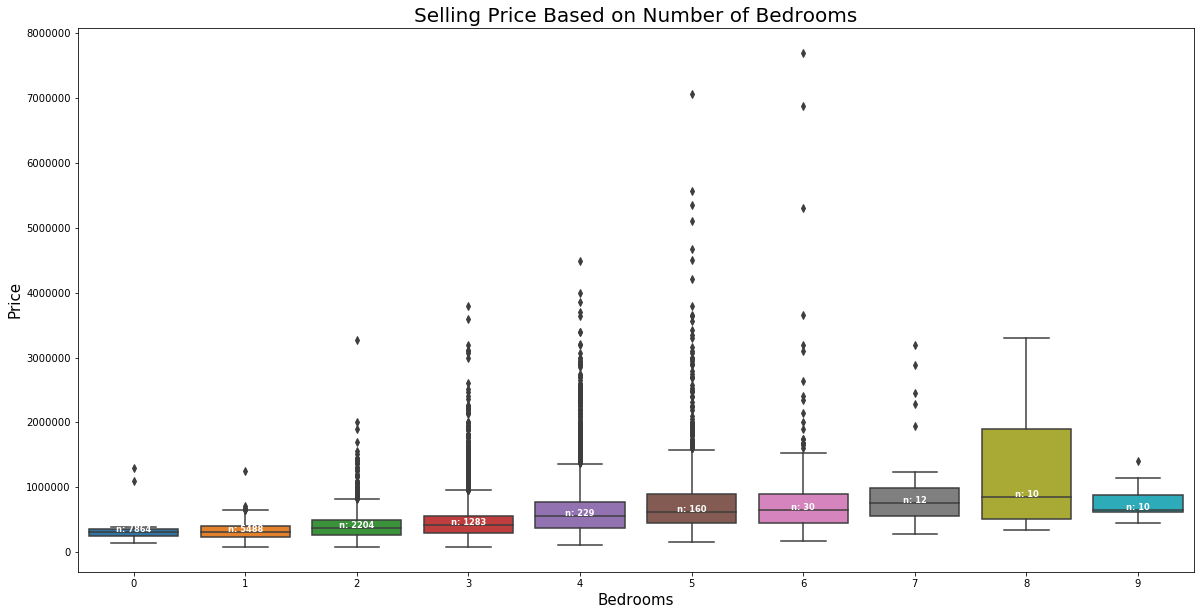

In [50]:
plt.figure(figsize=(20,10))
ax = sns.boxplot(x=df['bedrooms'], y=df['price'], data=df)
 
# Calculate number of obs per group & median to position labels
medians = df.groupby(['bedrooms'])['price'].median().values
nobs = df['bedrooms'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 0.03, nobs[tick],
horizontalalignment='center', size='small', color='w', weight='semibold')
    
plt.title('Selling Price Based on Number of Bedrooms', size=20)
plt.ylabel('Price', size=15)
plt.xlabel('Bedrooms', size=15)

plt.show()

## Waterfront

Text(0.5, 0, 'Waterfront Property')

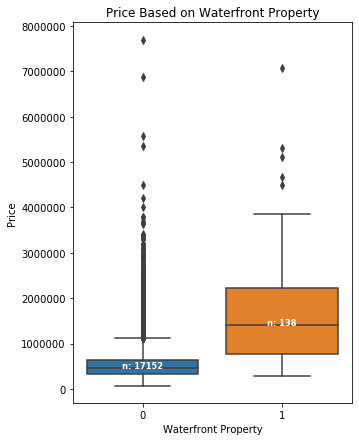

In [51]:
## Boxplot of Waterfront v. Price
plt.figure(figsize=(5,7))
ax = sns.boxplot(x=df['waterfront'], y=df['price'], data=df)
 
# Calculate number of obs per group & median to position labels
medians = df.groupby(['waterfront'])['price'].median().values
nobs = df['waterfront'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 0.03, nobs[tick],
horizontalalignment='center', size='small', color='w', weight='semibold')
    
plt.title('Price Based on Waterfront Property')
plt.ylabel('Price')
plt.xlabel('Waterfront Property')

## View

Text(0.5, 0, 'View')

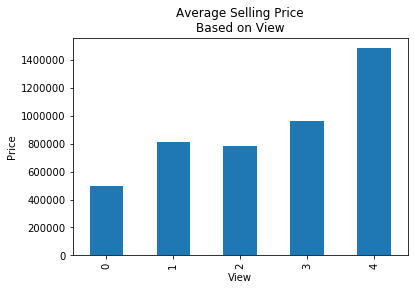

In [52]:
#Barplot Price v number of floors
df.groupby('view')['price'].mean().plot(kind='bar')

#Set labels
plt.title('Average Selling Price\nBased on View', size=12)
plt.ylabel('Price')
plt.xlabel('View')

Text(0.5, 0, 'View Rating')

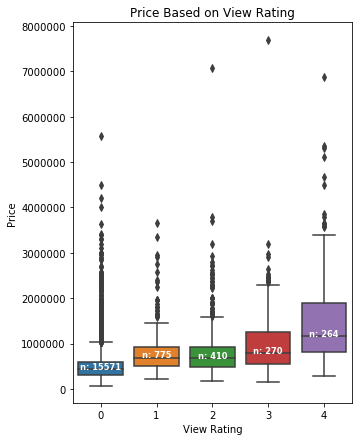

In [53]:
## Boxplot of View v. Price
plt.figure(figsize=(5,7))
ax = sns.boxplot(x=df['view'], y=df['price'], data=df)
 
# Calculate number of obs per group & median to position labels
medians = df.groupby(['view'])['price'].median().values
nobs = df['view'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 0.03, nobs[tick],
horizontalalignment='center', size='small', color='w', weight='semibold')
    
plt.title('Price Based on View Rating')
plt.ylabel('Price')
plt.xlabel('View Rating')

## Condition

Text(0.5, 0, 'Condition')

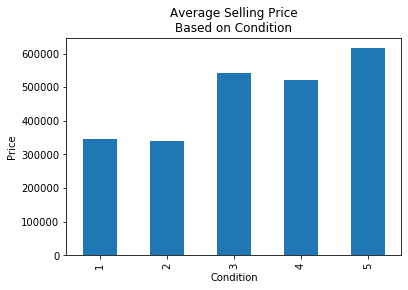

In [54]:
#Barplot Price v number of floors
df.groupby('condition')['price'].mean().plot(kind='bar')

#Set labels
plt.title('Average Selling Price\nBased on Condition', size=12)
plt.ylabel('Price')
plt.xlabel('Condition')

Text(0.5, 0, 'Condition Quality')

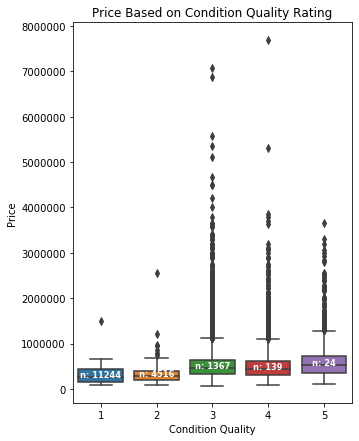

In [55]:
## Boxplot of Condition v. Price
plt.figure(figsize=(5,7))
ax = sns.boxplot(x=df['condition'], y=df['price'], data=df)
 
# Calculate number of obs per group & median to position labels
medians = df.groupby(['condition'])['price'].median().values
nobs = df['condition'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 0.03, nobs[tick],
horizontalalignment='center', size='small', color='w', weight='semibold')
    
# Set labels
plt.title('Price Based on Condition Quality Rating')
plt.ylabel('Price')
plt.xlabel('Condition Quality')

Text(0.5, 0, 'Condition')

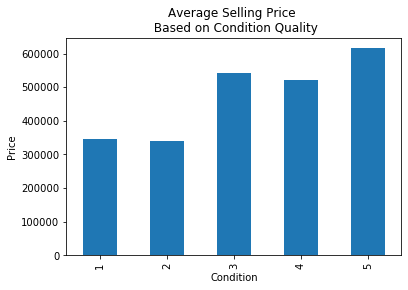

In [56]:
#Barplot Average Price v Condition Rating
df.groupby('condition')['price'].mean().plot(kind='bar')

#Set labels
plt.title('Average Selling Price \n Based on Condition Quality', size=12)
plt.ylabel('Price')
plt.xlabel('Condition')

In [57]:
# separate condition into 3 categories: 1/2, 3/4, and 5

# condition = [
#     (df.condition.values == 1) & (df.condition.values == 2),
#     (df.condition.values == 3) & (df.condition.values == 4),
#     (df.condition.values == 5)]

# choices = [
#     1, 
#     2, 
#     3,]

# df.conditions = np.select(conditions, choices, default='NA')

In [58]:
## RUN CELL ONCE
#Create dummy columns using 'condition2'
# df = pd.get_dummies(df, columns=['condition'])

# Step 3: Clean
- already took care of bedroom outliers with Read-In
- reining in square footage outliers
- work on binning 
    - `condition` into 3 categories: 1/2, 3/4, and 5
    - `view` into 3 categories: 0, 1&2, 3, 4 (or create poly?)

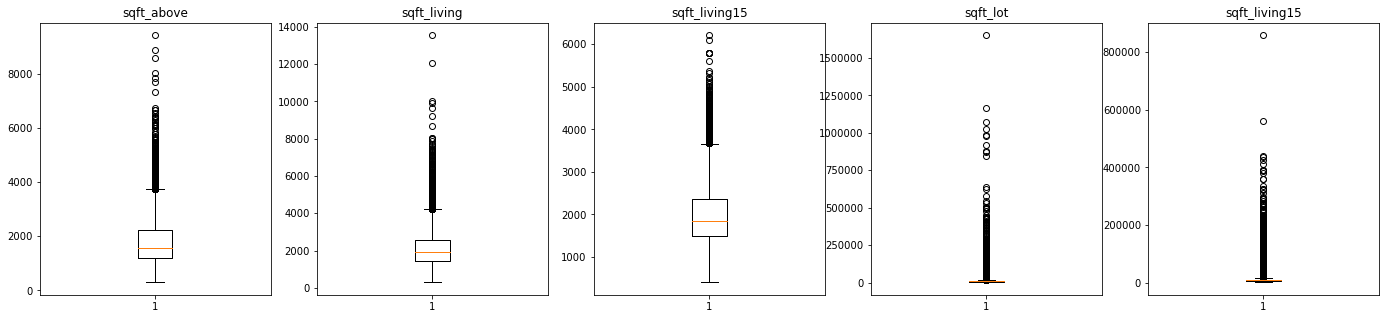

In [59]:
# Investigating Square footage outliers

plt.figure(figsize=(24,5))

ax3 = plt.subplot(1, 5, 1)
plt.boxplot(df.sqft_above)
ax3.set_title('sqft_above')

ax1 = plt.subplot(1, 5, 2)
plt.boxplot(df.sqft_living)
ax1.set_title('sqft_living')

ax2 = plt.subplot(1, 5, 3)
plt.boxplot(df.sqft_living15)
ax2.set_title('sqft_living15')


ax3 = plt.subplot(1, 5, 4)
plt.boxplot(df.sqft_lot)
ax3.set_title('sqft_lot')

ax3 = plt.subplot(1, 5, 5)
plt.boxplot(df.sqft_lot15)
ax3.set_title('sqft_living15')

plt.show()

In [6]:
# adjuting sqft home outliers to within 6 standard deviations of the mean
for col in ['sqft_above', 'sqft_living', 'sqft_living15']: 
    above_6std = df[col].mean()+(6*df[col].std())
    df[col] = np.where(df[col].values >above_6std, df[col].mean()+6*df[col].std(), df[col])
    
# adjusting lot outliers to within 9 standard deviations of the mean
for col in ['sqft_lot', 'sqft_lot15']: 
    above_9std = df[col].mean()+(9*df[col].std())
    df[col] = np.where(df[col].values >above_6std, df[col].mean()+9*df[col].std(), df[col])

# Try these to see if they improve model

In [7]:
# Create Bins for Grade 1-4, 5-7, 8-13
cut_labels1 = [1, 2, 3]
cut_bins1 = [0, 4, 7, 13]
df['cut_grade'] = pd.cut(df['grade'], bins=cut_bins1, labels=cut_labels1)
df['cut_grade'] = pd.to_numeric(df['cut_grade'],errors='coerce')
df = df.drop(['grade'], axis=1)

In [8]:
# Create Bins for Condition 1-2, 3-4, 5
cut_labels2 = [1, 2, 3]
cut_bins2 = [0, 2, 4, 5]
df['cut_condition'] = pd.cut(df['condition'], bins=cut_bins2, labels=cut_labels2)
df['cut_condition'] = pd.to_numeric(df['condition'],errors='coerce')
df = df.drop(['condition'], axis=1)

In [9]:
# # Create Bins for View 0, 1-2, 3, 4
# cut_labels3 = [0, 1, 2]
# cut_bins3 = [1, 2, 3, 4]
# df['cut_view'] = pd.cut(df['view'], bins=cut_bins3, labels=cut_labels3)
# df['cut_view'] = pd.to_numeric(df['cut_view'],errors='coerce')

In [10]:
#Create dummy columns of 'view'
df = pd.get_dummies(df, columns=['view'], drop_first=True)

In [11]:
#Create dummy columns of 'floors'
df = pd.get_dummies(df, columns=['floors'], drop_first=True)

# Step 4: Generate new features that you think could be important.

After doing this, you will want to go back to steps 2 and 3 to investigate these new features.

# Create new features with lat/long here!!

In [15]:
## RUN THIS CELL ONLY ONCE!

#Create new column 'age' for age of house
df['age'] = 2020 - df.yr_built

#Create dummy variable 'basement' y/n
df['basement'] = np.where(df['sqft_basement']>0 , 1, 0)
df = pd.get_dummies(df, columns=['basement'])
df = df.drop(['basement_0'], axis=1)

#Create a new column 'neighbors_compared' with sqft_living - sqft_living15
df['neighbors_compared'] = df.sqft_living - df.sqft_living15

#Create dummy columns using 'nc_2'
df['nc2'] = np.where(df['sqft_living']> df['sqft_living15'] , 1, 0)
df = pd.get_dummies(df, columns=['nc2'])
df = df.drop(['nc2_0'], axis=1)


Playing with `renovated` columns:

In [12]:
#Create new column 'last_renovted' for how long ago since last renovation
df['last_ren'] = np.where(df['yr_renovated'] > 0, (2020 - df['yr_renovated']), 0) ##np.nan may break this code... find out a way to make '0' into null value

#Create new column 'last_ren2' for how long (years) since last renovation and including age if no renovation
df['last_ren2'] = np.where(df['yr_renovated'] > 0, (2020 - df['yr_renovated']), (2020 - df['yr_built']))

#Create dummy columns using 'renovated'
df['renovated'] = np.where(df['yr_renovated']>0 , 1, 0)
df = pd.get_dummies(df, columns=['renovated'], drop_first=True)


#### Create dummy zip codes

In [13]:
# Create dummy variables for zipcodes
zip_dummies = pd.get_dummies(df['zipcode'].astype(str), drop_first=True)

#df.drop(columns=['zipcode'],inplace=True)
#zips = 'zip'+zip_dummies.columns
# zip_dummies.columns = zips
# zip_dummies.head()

In [70]:
zip_dummies.head()

,98002,98003,98004,98005,98006,98007,98008,98010,98011,98014,98019,98022,98023,98024,98027,98028,98029,98030,98031,98032,98033,98034,98038,98039,98040,98042,98045,98052,98053,98055,98056,98058,98059,98065,98070,98072,98074,98075,98077,98092,98102,98103,98105,98106,98107,98108,98109,98112,98115,98116,98117,98118,98119,98122,98125,98126,98133,98136,98144,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Checking on new features

In [74]:
#Run below cell for correlation matrix

In [75]:
# # Correlation matrix
# fig, ax = plt.subplots(figsize=(20, 15))

# corr = df.corr()

# # Generate a mask for the upper triangle
# mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

# sns.heatmap(corr, mask=mask, cmap='bwr', center=0, annot=True)

# # fix for matplotlib bug that cuts off top/bottom of seaborn viz
# b, t = plt.ylim() # discover the values for bottom and top
# b += 0.5 # Add 0.5 to the bottom
# t -= 0.5 # Subtract 0.5 from the top
# plt.ylim(b, t) # update the ylim(bottom, top) values

# plt.show()

In [76]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,waterfront,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yr_sold,month_sold,floors_x_sqft_living,cut_grade,cut_condition,view_1,view_2,view_3,view_4,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,age,basement_1,neighbors_compared,nc2_1,last_ren,last_ren2,renovated_1
0,365000.0,4,2.25,2070.0,395985.013979,0,2070.0,0,1986,0,98058,47.4388,-122.162,2390.0,257920.414075,2014,10,4140.0,3,4,0,0,0,0,0,1,0,0,0,34,0,-320.0,0,0,34,0
1,865000.0,5,3.00,2900.0,395985.013979,0,1830.0,1070,1977,0,98115,47.6784,-122.285,2370.0,257920.414075,2014,8,2900.0,3,5,0,0,0,0,0,0,0,0,0,43,1,530.0,1,0,43,0
2,1038000.0,4,2.50,3770.0,395985.013979,0,3770.0,0,1997,0,98006,47.5646,-122.129,3710.0,257920.414075,2014,8,7540.0,3,3,0,1,0,0,0,1,0,0,0,23,0,60.0,1,0,23,0
3,1490000.0,3,3.50,4560.0,395985.013979,0,4560.0,0,1990,0,98034,47.6995,-122.228,4050.0,257920.414075,2015,3,9120.0,3,3,0,1,0,0,0,1,0,0,0,30,0,510.0,1,0,30,0
4,711000.0,3,2.50,2550.0,5376.000000,0,2550.0,0,2004,0,98052,47.6647,-122.083,2250.0,4050.000000,2014,7,5100.0,3,3,0,0,0,0,0,1,0,0,0,16,0,300.0,1,0,16,0


In [77]:
# #Checking on new features
# sns.pairplot(df[['age', 'last_ren', 'last_ren2', 'neighbors_compared', 'renovated_1', 'basement_1', 'price']], corner=True)


In [78]:
list(df.columns)

['price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'waterfront',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'yr_sold',
 'month_sold',
 'floors_x_sqft_living',
 'cut_grade',
 'cut_condition',
 'view_1',
 'view_2',
 'view_3',
 'view_4',
 'floors_1.5',
 'floors_2.0',
 'floors_2.5',
 'floors_3.0',
 'floors_3.5',
 'age',
 'basement_1',
 'neighbors_compared',
 'nc2_1',
 'last_ren',
 'last_ren2',
 'renovated_1']

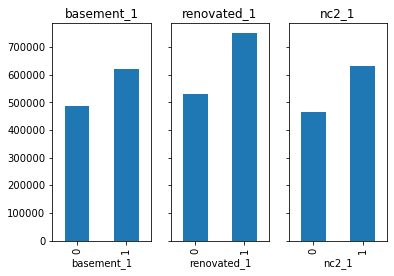

In [16]:
# Create bar plots
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True)

categoricals = ['basement_1', 'renovated_1', 'nc2_1']

for col, ax in zip(categoricals, axes.flatten()):
    (df.groupby(col).mean()['price']
         .sort_values()              # sort the groups in ascending order if desired
         .plot.bar(ax=ax))
    ax.set_title(col)
#fig.tight_layout()

In [80]:
# # Concat df and zip dummies DFs -- do this after polynomials!!
# df = pd.concat([df, zip_dummies], axis=1)

### <ins>Non-linear transformations</ins>

### 4.4) Create a polynomial feature for two of your continuous variables.

In [83]:
#df.head() # Sanity Check to remove dummy variables

In [17]:
list(df.iloc[:,1:])

['price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'waterfront',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'price_by_sqft',
 'floors_x_sqft_living',
 'cut_grade',
 'cut_condition',
 'view_1',
 'view_2',
 'view_3',
 'view_4',
 'floors_1.5',
 'floors_2.0',
 'floors_2.5',
 'floors_3.0',
 'floors_3.5',
 'last_ren',
 'last_ren2',
 'renovated_1',
 'age',
 'basement_1',
 'neighbors_compared',
 'nc2_1']

In [85]:
# feature_cols = list(df.iloc[:,1:])
# feature_cols

In [18]:
list_features = list(df.iloc[:,1:])
#list_features

In [87]:
# df['bedroomsXbathrooms'] = df.bedrooms*df.bathrooms
# df.head()


,price,bedrooms,bathrooms,sqft_living,sqft_lot,waterfront,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yr_sold,month_sold,floors_x_sqft_living,cut_grade,cut_condition,view_1,view_2,view_3,view_4,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,age,basement_1,neighbors_compared,nc2_1,last_ren,last_ren2,renovated_1,bedroomsXbathrooms
0,365000.0,4,2.25,2070.0,395985.013979,0,2070.0,0,1986,0,98058,47.4388,-122.162,2390.0,257920.414075,2014,10,4140.0,3,4,0,0,0,0,0,1,0,0,0,34,0,-320.0,0,0,34,0,9.0
1,865000.0,5,3.00,2900.0,395985.013979,0,1830.0,1070,1977,0,98115,47.6784,-122.285,2370.0,257920.414075,2014,8,2900.0,3,5,0,0,0,0,0,0,0,0,0,43,1,530.0,1,0,43,0,15.0
2,1038000.0,4,2.50,3770.0,395985.013979,0,3770.0,0,1997,0,98006,47.5646,-122.129,3710.0,257920.414075,2014,8,7540.0,3,3,0,1,0,0,0,1,0,0,0,23,0,60.0,1,0,23,0,10.0
3,1490000.0,3,3.50,4560.0,395985.013979,0,4560.0,0,1990,0,98034,47.6995,-122.228,4050.0,257920.414075,2015,3,9120.0,3,3,0,1,0,0,0,1,0,0,0,30,0,510.0,1,0,30,0,10.5
4,711000.0,3,2.50,2550.0,5376.000000,0,2550.0,0,2004,0,98052,47.6647,-122.083,2250.0,4050.000000,2014,7,5100.0,3,3,0,0,0,0,0,1,0,0,0,16,0,300.0,1,0,16,0,7.5


In [19]:
poly_cols = ['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'sqft_above',
 'sqft_basement',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
# 'floors_x_sqft_living',
 'cut_grade',
 'cut_condition',
 'age',
 'neighbors_compared',
 'last_ren',
 'last_ren2'
]

In [20]:
#poly2_features = pd.DataFrame()
df_poly3_features = pd.DataFrame()

# for feat in poly_cols:
#     poly2_features[feat+'^2'] = df[feat]**2
for feat in poly_cols:    
    df_poly3_features[feat+'^3'] = df[feat]**3
    

In [21]:
df_poly3_features.head()

,bedrooms^3,bathrooms^3,sqft_living^3,sqft_lot^3,sqft_above^3,sqft_basement^3,lat^3,long^3,sqft_living15^3,sqft_lot15^3,cut_grade^3,cut_condition^3,age^3,neighbors_compared^3,last_ren^3,last_ren2^3
0,64,11.390625,8.869743e+09,6.209209e+16,8.869743e+09,0,106758.160996,-1.823091e+06,1.365192e+10,1.715762e+16,27,64,39304,-32768000.0,0,39304
1,125,27.000000,2.438900e+10,6.209209e+16,6.128487e+09,1225043000,108383.960963,-1.828604e+06,1.331205e+10,1.715762e+16,27,125,79507,148877000.0,0,79507
2,64,15.625000,5.358263e+10,6.209209e+16,5.358263e+10,0,107609.731195,-1.821614e+06,5.106481e+10,1.715762e+16,27,27,12167,216000.0,0,12167
3,27,42.875000,9.481882e+10,6.209209e+16,9.481882e+10,0,108527.920101,-1.826048e+06,6.643012e+10,1.715762e+16,27,27,27000,132651000.0,0,27000
4,27,15.625000,1.658138e+10,1.553738e+11,1.658138e+10,0,108290.558060,-1.819557e+06,1.139062e+10,6.643012e+10,27,27,4096,27000000.0,0,4096


In [91]:
# df_poly2_features = pd.concat([df, poly2_features, zip_dummies], axis=1)

In [92]:
# df_poly3_features = pd.concat([df_features, df_poly3_features, zip_dummies], axis=1) --- CONCAT LATER

### 4.5) Create an interaction feature between a binary variable (dummy variable) and a continuous variable.

In [93]:
# binary_vars = 
# continuous_vars = 

In [94]:
# your code here

In [95]:
# Adding zips to df

# Step 5: Train-Test Split

### 5.1) Perform a train-test split of the data.

This code will need to be re-run with list(df.columns) if features are added

In [96]:
#Inspecting columns to concat dfs together
#list(df.columns)
#list(df_poly2_features.columns)
#list(df_poly3_features.columns)

In [22]:
# Concat DFs together
df_zips = pd.concat([df, zip_dummies], axis=1)

In [23]:
df_zips = df.iloc[:,1:]
target = df['price']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df_zips, target, random_state=42,test_size=0.2)

#check the shape of the results
print("Training set - Features: ", X_train.shape, "Target: ", y_train.shape)
print("Training set - Features: ", X_test.shape, "Target: ",y_test.shape)

Training set - Features:  (13832, 35) Target:  (13832,)
Training set - Features:  (3458, 35) Target:  (3458,)


# Log
before extra feature engineering
- LOG Training RMSE: 110802
- LOG Testing RMSE:  164965

after edits:
- LOG Training RMSE: 203947
- LOG Testing RMSE:  177469

#### Poly 3 With Lasso - will need a scaler
- Training RMSE:
- Testing RMSE:

In [101]:
df_zips = pd.concat([df, zip_dummies], axis=1)
#df_zips.head() #Sanity Check

In [102]:
y_log = np.log(y_train)

# instantiate a linear regression object and fit
lm_log = LinearRegression()
lm_log = lm_log.fit(X_train, y_log)

In [103]:
log_train_pred = lm_log.predict(X_train)

# exponentiate the predictions to get them on the same original scale 
y_train_pred = np.exp(log_train_pred)
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

print('LOG Training Root Mean Squared Error:' , train_rmse)

LOG Training Root Mean Squared Error: 189124.81940299852


In [104]:
log_test_pred = lm_log.predict(X_test)

# exponentiate the predictions to get them on the same original scale 
log_test_pred = np.exp(log_test_pred)
log_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, log_test_pred))

print('LOG Training RMSE:' , int(train_rmse))
print('LOG Testing RMSE: ' , int(log_test_rmse))

LOG Training RMSE: 189124
LOG Testing RMSE:  188381


In [105]:
# Checking mae vs rmse
metrics.mean_absolute_error(y_train, y_train_pred) 

111011.54177030172

In [106]:
# #If we decide to use Log, run this cell!!

# # reassign y_test_pred to our log model
# y_test_pred = lm_log.predict(X_test)

# #our model predicted the log of gross, so now we must exponentiate to get value back in $
# y_test_pred = np.exp(y_test_pred)

# test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

# #print('Testing Root Mean Squared Error:' , test_rmse)
# print('Training: ', int(train_rmse), "vs. Testing: ", int(test_rmse))

# Log
with `df[list_features)` (no polys)
- LOG Training RMSE: 133865
- LOG Testing RMSE:  140795


In [107]:
features = df.iloc[:,1:].columns
#df[features]

In [108]:
X_train, X_test, y_train, y_test = train_test_split(df[features], target, random_state=42,test_size=0.2)
# X_train.head() #Sanity Check

In [109]:
y_log = np.log(y_train)

# instantiate a linear regression object and fit
lm_log = LinearRegression()
lm_log = lm_log.fit(X_train, y_log)

In [110]:
log_train_pred = lm_log.predict(X_train)

# exponentiate the predictions to get them on the same original scale 
y_train_pred = np.exp(log_train_pred)
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

print('LOG Training Root Mean Squared Error:' , train_rmse)

LOG Training Root Mean Squared Error: 189124.81940299852


In [111]:
log_test_pred = lm_log.predict(X_test)

# exponentiate the predictions to get them on the same original scale 
log_test_pred = np.exp(log_test_pred)
log_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, log_test_pred))

print('LOG Training RMSE:' , int(train_rmse))
print('LOG Testing RMSE: ' , int(log_test_rmse))

LOG Training RMSE: 189124
LOG Testing RMSE:  188381


In [112]:
# Checking mae vs rmse
metrics.mean_absolute_error(y_train, y_train_pred) 

111011.54177030172

In [113]:
# #If we decide to use Log, run this cell!!

# # reassign y_test_pred to our log model
# y_test_pred = lm_log.predict(X_test)

# #our model predicted the log of gross, so now we must exponentiate to get value back in $
# y_test_pred = np.exp(y_test_pred)

# test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

# #print('Testing Root Mean Squared Error:' , test_rmse)
# print('Training: ', int(train_rmse), "vs. Testing: ", int(test_rmse))

# Polynomial Features

## Poly 2

#### with Log, no feature selection
- Training RMSE:  151,662
- Testing RMSE: 528,977

#### with Log and Lasso -
- Poly2 Training RMSE: 106,307
- Poly2 Testing RMSE: 177,626

after zips
- Training RMSE: 79,093
- **Testing RMSE: 138,793 *Best**

#### Poly with Log and Kbest (83 features)
- KBEST Training RMSE: 171,302
- KBEST Testing RMSE: 170,581

without Log, with Kbest?

#### Poly with Log and RFE (after zips)
- RFE Training RMSE: 179,763
- RFE Testing RMSE: 170,627

##### Poly2 with log, no feature selection

In [114]:
poly_features = df_zips
target = df['price']
# df_zips.head() #Sanity Check

In [115]:
# poly_features = df[list_features]
# target = df['price']

In [116]:
poly_2 = PolynomialFeatures(degree=2, include_bias=False)
poly2_data = poly_2.fit_transform(poly_features)
poly2_columns = poly_2.get_feature_names(poly_features.columns)
df_poly2 = pd.DataFrame(poly2_data, columns=poly2_columns)


In [117]:
df_poly2.shape

(17290, 5777)

In [118]:
df_poly2.head() #Sanity Check

,price,bedrooms,bathrooms,sqft_living,sqft_lot,waterfront,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yr_sold,month_sold,floors_x_sqft_living,cut_grade,cut_condition,view_1,view_2,view_3,view_4,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,age,basement_1,neighbors_compared,nc2_1,last_ren,last_ren2,renovated_1,bedroomsXbathrooms,98002,98003,98004,98005,98006,98007,98008,98010,98011,98014,98019,98022,98023,98024,98027,98028,98029,98030,98031,98032,98033,98034,98038,98039,98040,98042,98045,98052,98053,98055,98056,98058,98059,98065,98070,98072,98074,98075,98077,98092,98102,98103,98105,98106,98107,98108,98109,98112,98115,98116,98117,98118,98119,98122,98125,98126,98133,98136,98144,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199,price^2,price bedrooms,price bathrooms,price sqft_living,price sqft_lot,price waterfront,price sqft_above,price sqft_basement,price yr_built,price yr_renovated,price zipcode,price lat,price long,price sqft_living15,price sqft_lot15,price yr_sold,price month_sold,price floors_x_sqft_living,price cut_grade,price cut_condition,price view_1,price view_2,price view_3,price view_4,price floors_1.5,price floors_2.0,price floors_2.5,price floors_3.0,price floors_3.5,price age,price basement_1,price neighbors_compared,price nc2_1,price last_ren,price last_ren2,price renovated_1,price bedroomsXbathrooms,price 98002,price 98003,price 98004,price 98005,price 98006,price 98007,price 98008,price 98010,price 98011,price 98014,price 98019,price 98022,price 98023,price 98024,price 98027,price 98028,price 98029,price 98030,price 98031,price 98032,price 98033,price 98034,price 98038,price 98039,price 98040,price 98042,price 98045,price 98052,price 98053,price 98055,price 98056,price 98058,price 98059,price 98065,price 98070,price 98072,price 98074,price 98075,price 98077,price 98092,price 98102,price 98103,price 98105,price 98106,price 98107,price 98108,price 98109,price 98112,price 98115,price 98116,price 98117,price 98118,price 98119,price 98122,price 98125,price 98126,price 98133,...,98116 98146,98116 98148,98116 98155,98116 98166,98116 98168,98116 98177,98116 98178,98116 98188,98116 98198,98116 98199,98117^2,98117 98118,98117 98119,98117 98122,98117 98125,98117 98126,98117 98133,98117 98136,98117 98144,98117 98146,98117 98148,98117 98155,98117 98166,98117 98168,98117 98177,98117 98178,98117 98188,98117 98198,98117 98199,98118^2,98118 98119,98118 98122,98118 98125,98118 98126,98118 98133,98118 98136,98118 98144,98118 98146,98118 98148,98118 98155,98118 98166,98118 98168,98118 98177,98118 98178,98118 98188,98118 98198,98118 98199,98119^2,98119 98122,98119 98125,98119 98126,98119 98133,98119 98136,98119 98144,98119 98146,98119 98148,98119 98155,98119 98166,98119 98168,98119 98177,98119 98178,98119 98188,98119 98198,98119 98199,98122^2,98122 98125,98122 98126,98122 98133,98122 98136,98122 98144,98122 98146,98122 98148,98122 98155,98122 98166,98122 98168,98122 98177,98122 98178,98122 98188,98122 98198,98122 98199,98125^2,98125 98126,98125 98133,98125 98136,98125 98144,98125 98146,98125 98148,98125 98155,98125 98166,98125 98168,98125 98177,98125 98178,98125 98188,98125 98198,98125 98199,98126^2,98126 98133,98126 98136,98126 98144,98126 98146,98126 98148,98126 98155,98126 98166,98126 98168,98126 98177,98126 98178,98126 98188,98126 98198,98126 98199,98133^2,98133 98136,98133 98144,98133 98146,98133 98148,98133 98155,98133 98166,98133 98168,98133 98177,98133 98178,98133 98188,98133 98198,98133 98199,98136^2,98136 98144,98136 98146,98136 98148,98136 98155,98136 98166,98136 98168,98136 98177,98136 98178,98136 98188,98136 98198,98136 98199,98144^2,98144 98146,98144 98148,98144 98155,98144 98166,98144 98168,98144 98177,98144 98178,98144 98188,98144 98198,98144 98199,98146^2,98146 98148,98146 98155,98146 98166,98146 98168,98146 98177,98146 98178,98146 98188,98146 98198,98146 98199,98148^2,98148 98155,98148 98166,98148 98168,98148 98177,98148 98178,98148 98188,98148 98198,9

In [119]:
# #this is a DF NOT including zip codes dummied against one another
df_poly2 = df_poly2.iloc[:, :-2415]

In [120]:
X_train, X_test, y_train, y_test = train_test_split(df_poly2, target, random_state=42,test_size=0.2)

In [121]:
# instantiate a linear regression object and fit to training data
lm_2 = LinearRegression()
lm_2 = lm_2.fit(X_train, y_train)

y_train_pred = lm_2.predict(X_train)

train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
print('Training Root Mean Squared Error:' , train_rmse)

Training Root Mean Squared Error: 1.390425705001974e-07


In [122]:
# use fitted model to predict on test data
y_pred = lm_2.predict(X_test)

test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print('Testing Root Mean Squared Error:' , test_rmse)
print('Training: ', int(train_rmse), "vs. Testing: ", int(test_rmse))

Testing Root Mean Squared Error: 3.630806833690693e-07
Training:  0 vs. Testing:  0


##### Poly2 Lasso with Log (remember to scale)
- Training Error: 106307
- Testing Error: 177626

after zips added:
- Training Error: 79093
- Testing Error: 138793

In [123]:
# ## training the model
# from sklearn.linear_model import Lasso

# lasso = Lasso(alpha=.1, normalize=False)

# lasso.fit(X_train,y_train)

# y_train_pred_lasso = lasso.predict(X_train)
# y_pred_lasso = lasso.predict(X_test)

# train_rmse_lasso01 = metrics.mean_absolute_error(y_train, y_train_pred_lasso)
# test_rmse_lasso01 = np.sqrt(metrics.mean_squared_error(y_test, y_pred_lasso))
# print('Training Error: '+ str(train_rmse_lasso01) )
# print('Testing Error: '+ str(test_rmse_lasso01) )

##### KBest with Log
20 variables
- Training Root Mean Squared Error: 192118
- Testing Root Mean Squared Error: 187339

Note: Run KBest without Log?

##### Poly2 log, KBest83 features
- KBEST Training Root Mean Squared Error: 171302
- KBEST Testing Root Mean Squared Error: 170581

did worse after zips added? (28 features):
- KBEST Training Root Mean Squared Error: 193908
- KBEST Testing Root Mean Squared Error: 187826

In [124]:
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression

selector = SelectKBest(f_regression, k=60) # <----- number of features you want
selector.fit(X_train, y_train)

selected_columns = X_train.columns[selector.get_support()] #kept columns
removed_columns = X_train.columns[~selector.get_support()] #removed columns
#list(selected_columns)
#list(removed_columns)

In [125]:
len(removed_columns)

3302

In [126]:
#instantiate a linear regression object and fit to train data
lm_kbest = LinearRegression()
lm_kbest.fit(X_train[selected_columns], y_train)

# Training Root Mean Squared Error
y_train_kbest = lm_kbest.predict(X_train[selected_columns])
trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_kbest))
print('KBEST Training Root Mean Squared Error:' , trainK_rmse)

# Testing Root Mean Squared Error
y_kbest = lm_kbest.predict(X_test[selected_columns])
testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_kbest))
print('KBEST Testing Root Mean Squared Error:' , testK_rmse)

KBEST Training Root Mean Squared Error: 9.037441603144977e-09
KBEST Testing Root Mean Squared Error: 8.032001784481543e-09


##### RFE with Log
- Training RMSE: 201,630
- Testing RMSE: 197,283

after zips
- Training RMSE: 179,763
- Testing RMSE: 170,627

after zips and extra features, no log?
- Training RMSE: 165148
- Testing RMSE: 157662

In [127]:
# from sklearn.feature_selection import RFECV

# ols = linear_model.LinearRegression()

# selector = RFECV(estimator=ols, step=1, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

# # Fit recursive feature eliminator 
# selector.fit(X_train, y_train)

In [128]:
# selected_rfe = X_train.columns[selector.support_]
# removed_rfe = X_train.columns[~selector.support_]
# # list(selected_rfe)
# # list(removed_rfe)

In [129]:
# #instantiate a linear regression object and fit to train
# lm_rfe = LinearRegression()
# lm_rfe = lm_rfe.fit(X_train[selected_rfe], y_train)

# # Train
# y_rfe = lm_rfe.predict(X_train[selected_rfe])
# trainRFE_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_rfe))
# print('Training RMSE:' , int(trainRFE_rmse))

# # Test
# y_pred_rfe = lm_rfe.predict(X_test[selected_rfe])
# testRFE_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfe))
# print('Testing RMSE:' , int(testRFE_rmse))

## Poly 3
performs worse than Poly2
#### Poly3 Log with Lasso:
- Training RMSE: 94810
- Testing RMSE: 191460
#### Poly3 Log and KBest (86 features) *best before zips?
- KBEST Training RMSE: 170993
- KBEST Testing RMSE: 169767

after adding zips:
- KBEST Training RMSE 193787
- KBEST Testing RMSE: 187970

In [130]:
# poly_3 = PolynomialFeatures(degree=3, include_bias=False)
# poly3_data = poly_3.fit_transform(df_features)
# poly3_columns = poly_3.get_feature_names(df_features.columns)
# df_poly3 = pd.DataFrame(poly3_data, columns=poly3_columns)
# df_poly3.head()

In [131]:
# # Concat dfs together to test
# df_poly3 = pd.concat([df_poly3, zip_dummies], axis=1)
# #df_poly3.head()

##### Poly3 with Lasso

In [132]:
# poly_3 = PolynomialFeatures(degree=3, include_bias=False)
# poly3_data = poly_3.fit_transform(df_features)
# poly3_columns = poly_3.get_feature_names(df_features.columns)
# df_poly3 = pd.DataFrame(poly3_data, columns=poly3_columns)
# #df_poly3.head() #Sanity Check

In [133]:
# X_train, X_test, y_train, y_test = train_test_split(df_poly3, target, random_state=42,test_size=0.2)

In [134]:
# # instantiate a linear regression object and fit to training data
# lm_3 = LinearRegression()
# lm_3 = lm_2.fit(X_train, y_train)

# y_train_pred = lm_3.predict(X_train)

# train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
# print('Training Root Mean Squared Error:' , train_rmse)

In [135]:
# # use fitted model to predict on test data
# y_pred = lm_3.predict(X_test)

# test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

# print('Testing Root Mean Squared Error:' , test_rmse)
# print('Training: ', int(train_rmse), "vs. Testing: ", int(test_rmse))

In [136]:
# lasso3 = Lasso(alpha=.1, normalize=False)

# lasso3.fit(X_train,y_train)

# y_train_pred_lasso3 = lasso3.predict(X_train)
# y_pred_lasso3 = lasso3.predict(X_test)

# train_rmse_lasso3 = metrics.mean_absolute_error(y_train, y_train_pred_lasso3)
# test_rmse_lasso3 = np.sqrt(metrics.mean_squared_error(y_test, y_pred_lasso3))
# print('Training Error: '+ str(train_rmse_lasso01) )
# print('Testing Error: '+ str(test_rmse_lasso01) )

##### Poly3 KBest

In [137]:
# from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression

# selector = SelectKBest(f_regression, k=31) # <----- f_regression and number of features you want
# selector.fit(X_train, y_train)

# selected_columns = X_train.columns[selector.get_support()] #kept columns
# removed_columns = X_train.columns[~selector.get_support()] #removed columns
# list(selected_columns)
# # list(removed_columns)

In [138]:
# #instantiate a linear regression object and fit to train data
# lm_kbest = LinearRegression()
# lm_kbest.fit(X_train[selected_columns], y_train)

# # Training Root Mean Squared Error
# y_train_kbest = lm_kbest.predict(X_train[selected_columns])
# trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_kbest))
# print('KBEST Training Root Mean Squared Error:' , trainK_rmse)

# # Testing Root Mean Squared Error
# y_kbest = lm_kbest.predict(X_test[selected_columns])
# testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_kbest))
# print('KBEST Testing Root Mean Squared Error:' , testK_rmse)

##### Poly3 RFE

In [139]:
# Run below cells only if you want computer to crash!:)

In [140]:
# from sklearn.feature_selection import RFECV
# ols = linear_model.LinearRegression()

# selector = RFECV(estimator=ols, step=1, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

# # Fit recursive feature eliminator 
# selector.fit(X_train, y_train)

In [141]:
# selected_rfe = X_train.columns[selector.support_]
# removed_rfe = X_train.columns[~selector.support_]
# # list(selected_rfe)
# # list(removed_rfe)

In [142]:
# #instantiate a linear regression object and fit to train
# lm_rfe = LinearRegression()
# lm_rfe = lm_rfe.fit(X_train[selected_rfe], y_train)

# # Train
# y_rfe = lm_rfe.predict(X_train[selected_rfe])
# trainRFE_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_rfe))
# print('Training Root Mean Squared Error:' , trainRFE_rmse)

# # Test
# y_pred_rfe = lm_rfe.predict(X_test[selected_rfe])
# testRFE_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfe))
# print('Testing Root Mean Squared Error:' , testRFE_rmse)

# Step 6: Utilize some different feature selection techniques before or in conjuction with fitting your models.

### 6.1) Utilize a filter method to identify some features to remove from the model.  

## Lasso

In [143]:
# ## training the model
# from sklearn.linear_model import Lasso

# lasso = Lasso(alpha=.1, normalize=False)

# lasso.fit(X_train,y_train)

# y_train_pred_lasso = lasso.predict(X_train)
# y_pred_lasso = lasso.predict(X_test)

# train_rmse_lasso01 = metrics.mean_absolute_error(y_train, y_train_pred_lasso)
# test_rmse_lasso01 = np.sqrt(metrics.mean_squared_error(y_test, y_pred_lasso))
# print('Training Error: '+ str(train_rmse_lasso01) )
# print('Testing Error: '+ str(test_rmse_lasso01) )

### 6.2) After removing the features, re-run Step 5 and see if your new model performs better than the old model.

In [144]:
# your code here

# Step 7: Evaluate your different models in order to determine the best model overall.

# Step 8:  Refit your best model to the entire dataset.

In [145]:
# # Poly2 model
# selector = SelectKBest(f_regression, k=83) # <----- number of features you want
# selector.fit(df_poly2, target)

# selected_columns = X_train.columns[selector.get_support()] #kept columns
# removed_columns = X_train.columns[~selector.get_support()] #removed columns

In [146]:
# # Poly3 model
# selector = SelectKBest(f_regression, k=86) # <----- f_regression and number of features you want
# selector.fit(df_poly3, target)

# selected_columns = X_train.columns[selector.get_support()] #kept columns
# removed_columns = X_train.columns[~selector.get_support()] #removed columns

In [147]:
#instantiate a linear regression object
lm_final = LinearRegression()

#fit the linear regression to the data
lm_final = lm_final.fit(df_poly2[selected_columns], target)
lm_log = lm_log.fit(X_train, y_log)

In [148]:
#list(selected_columns)

## Checking model attributes to copy to holdout notebook

In [149]:
#list(df_poly2[selected_columns].columns)

In [150]:
len(lm_final.coef_)

60

# Step 9: Save your final model using pickle.

https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/

In [151]:
import pickle

#Model
pickle_out = open("test2_poly2_model.pickle","wb")
pickle.dump(lm_final, pickle_out)
pickle_out.close()